# Criando um modelo de Machine Learning
Nesse notebook vamos preparar os dados que utilizaremos ao longo do desenvolvimento do projeto. Os datasets aqui utilizados são importados do portal de dados abertos da UFRN (http://dados.ufrn.br/).

Para esse estudo, analisaremos apenas os dados do curso de Ciência e Tecnologia da UFRN, mais espeficamente a disciplina de Cálculo 2, onde tentaremos prever as possiveis reprovações dos alunos se baseando em seu histórico e na nota da primeira unidade na disciplina.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
# Importando os dados das matriculas
matriculas = pd.read_csv("data/matriculas_c2_pos_novos_indicadores.csv", sep=";")

In [3]:
print(f'Shape matrícula: {matriculas.shape}')

Shape matrícula: (2262, 15)


In [4]:
matriculas.columns

Index(['discente', 'faltas_unidade', 'id_turma', 'media_final', 'nota',
       'numero_total_faltas', 'reposicao', 'unidade', 'reprovou',
       'desempenho_exatas', 'historico_reprovacao', 'primeira_vez_pagando',
       'n1_std_turma', 'prof_c1_tx_reprovacao', 'professor_tx_reprovao'],
      dtype='object')

## Removendo Duplicates

In [5]:
alunos = matriculas.drop_duplicates()

In [6]:
alunos.shape

(2262, 15)

## Análise dos dados de matrícula do Aluno


---


Vamos tentar entender melhor quais das features presentes na matrícula do aluno são importantes para a predição da sua evasão.

In [7]:
alunos.groupby('reprovou').reprovou.count()

reprovou
False    1023
True     1239
Name: reprovou, dtype: int64

## Feature Engineering
Construindo novas features e preparando os dados

In [8]:
alunos.columns

Index(['discente', 'faltas_unidade', 'id_turma', 'media_final', 'nota',
       'numero_total_faltas', 'reposicao', 'unidade', 'reprovou',
       'desempenho_exatas', 'historico_reprovacao', 'primeira_vez_pagando',
       'n1_std_turma', 'prof_c1_tx_reprovacao', 'professor_tx_reprovao'],
      dtype='object')

In [9]:
alunos = alunos[['nota', 'n1_std_turma', 'desempenho_exatas', 'primeira_vez_pagando',
       'historico_reprovacao', 'prof_c1_tx_reprovacao', 'professor_tx_reprovao', 'reprovou']]

## Análisando Correlações

In [10]:
num_corr_matrix = alunos.corr()
num_corr_target = num_corr_matrix['reprovou'].sort_values(ascending=False)
num_corr_matrix['reprovou'].values[:-1]

array([-0.65500215, -0.6122143 , -0.22327422,  0.03712059,  0.12002882,
               nan,  0.11315837])

<AxesSubplot:>

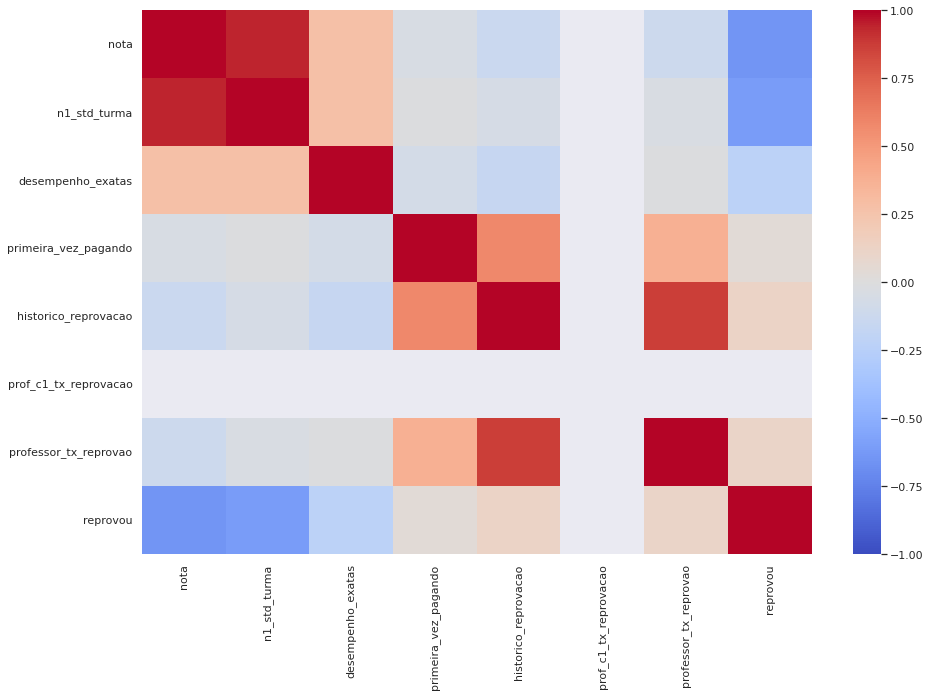

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(num_corr_matrix, ax=ax, annot=False, cmap='coolwarm', vmin=-1., vmax=1.)

In [12]:
alunos.isna().sum()

nota                      0
n1_std_turma              0
desempenho_exatas         0
primeira_vez_pagando      0
historico_reprovacao      0
prof_c1_tx_reprovacao     0
professor_tx_reprovao    71
reprovou                  0
dtype: int64

In [19]:
alunos.professor_tx_reprovao.fillna(alunos.professor_tx_reprovao.median(), inplace=True)

# Análise do Modelo de Machine Learning
Apresentando os resultados encontrados com o algoritmo RandomFlorestClassifier. Esse algoritmo está sendo utilizado por padrão nessa análise pois apresentou um resultado satisfatório nos testes apresentados anteriormente.

Segundo a Matriz de Confusão a taxa de dispersão dos 

In [13]:
from sklearn.model_selection import train_test_split

In [20]:
X = alunos.drop("reprovou", axis=1)
y = alunos.reprovou.values

y.shape

(2262,)

In [21]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

### Preparando os modelos

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [23]:
clf = RandomForestClassifier(class_weight = 'balanced', n_estimators=10)

In [24]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=10)

### Grid Search
Só rodar na primeira vez de cada teste.

In [38]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {"n_estimators": [10, 100],
#               "max_features": ['auto'],
#               "min_samples_leaf": [1, 2, 3, 5],
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}


# grid_search = GridSearchCV(clf, param_grid = param_grid)
# grid_search.fit(X_train, y_train)

/home/rafael/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 100], 'max_features': ['auto'], 'min_samples_leaf': [1, 2, 3, 5], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
# grid_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'n_estimators': 100}

In [25]:
best_params = {'bootstrap': True,
 'criterion': 'gini',
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'n_estimators': 100}
# {'bootstrap': True,
#  'criterion': 'entropy',
#  'max_features': 'auto',
#  'min_samples_leaf': 3,
#  'n_estimators': 100}

clf_best = RandomForestClassifier(bootstrap=best_params['bootstrap'], criterion=best_params['criterion'], max_features=best_params['max_features'], 
                                  min_samples_leaf=best_params['min_samples_leaf'], n_estimators=best_params['n_estimators'], class_weight = 'balanced')

In [26]:
clf_best.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2)

In [27]:
y_pred = clf_best.predict(X_test)

In [43]:
# y_pred = clf.predict(X_test)

In [28]:
accuracy = accuracy_score(y_test, y_pred)

In [29]:
from sklearn.model_selection import cross_val_score

## Apresentando os resultados

In [30]:
# 10-Fold Cross validation
print("Accuracy geral:")
print(np.mean(cross_val_score(clf_best, X_train, y_train, cv=10)))

Accuracy geral:
0.7943370165745856


In [31]:
# Melhores Features
clf.feature_importances_

array([0.406087  , 0.34474166, 0.11678158, 0.02137997, 0.05240197,
       0.        , 0.05860782])

In [32]:
X_train.columns

Index(['nota', 'n1_std_turma', 'desempenho_exatas', 'primeira_vez_pagando',
       'historico_reprovacao', 'prof_c1_tx_reprovacao',
       'professor_tx_reprovao'],
      dtype='object')

## Curva ROC e Matriz de Confusão

In [33]:
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')

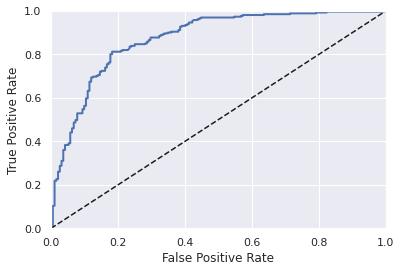

AUC: 0.872266


In [34]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#CURVA ROC
fig = plt.figure()
y_probas = cross_val_predict(clf_best, X_test, y_test, cv=10, method="predict_proba") 

y_scores = y_probas[:, 1]   # score = proba of positive class 
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plot_roc_curve(fpr, tpr) 
plt.show()
print("AUC: %f" % roc_auc_score(y_test, y_scores))

              precision    recall  f1-score   support

       False       0.80      0.78      0.79       192
        True       0.84      0.85      0.85       261

    accuracy                           0.82       453
   macro avg       0.82      0.82      0.82       453
weighted avg       0.82      0.82      0.82       453



Text(89.18, 0.5, 'predicted label')

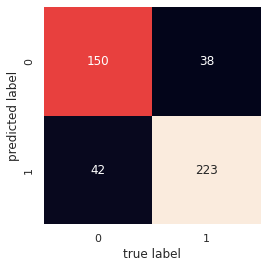

In [35]:
from sklearn.metrics import classification_report

#avaliacao
print(classification_report(y_test, y_pred))    
    
#Evaluating
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')